# Predict Future Sales

* Time series data consisting of daily sales from Russian software company.
* Historical data available from Jan 2013 to Oct 2015.
* Predict total sales for every product and store for Nov 2015, at the monthly level.
* List of shops and products changes slightly every month.

## 1. Load Data

In [1]:
## Load library 
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime, timedelta
from category_encoders import TargetEncoder 
import xgboost as xgb

np.random.seed(123)

# Load data
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')
item_cat = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

## Load translated data
shops_trans = pd.read_csv('data/shops-translated.csv')
items_trans = pd.read_csv('data/items-translated.csv')
item_cat_trans = pd.read_csv('data/item_categories-translated.csv')

In [2]:
## Function to downcast data

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
                
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
                
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    
    return df  

## 2. Creating Dataset

* Combine train and test data using `merge` with `how=outer`. This will include all products in train and test datasets.  Products that are not in the train data should have sales=0 in this combined data. 
* Aggregate to monthly level.
* Merge `sales_train`, supplemental datasets containing names of shops and item categories.
* Also include translated datasets for the Russian names. 
* Downcast dataset.
* Create new features for modelling:
    - city, item type, item subtype. 
    - mean encode all categorical variables. 
    - revenue variable = `item_price` * `item_cnt_month`.



### 2.1 Aggregate to monthly

In [3]:
def create_monthly(istrain=True):
    if istrain:
        ## Merge train and test data to get items
        df = pd.merge(sales_train, test, how='outer')
        df.drop(['ID'], axis=1, inplace=True)
        df['item_cnt_day'] = (df['item_cnt_day'].fillna(0))

        ## Aggregate data to monthly
        df['item_cnt_day'] = df['item_cnt_day'].clip(0,20)
        df = df.groupby(['date_block_num', 'shop_id', 'item_id'])\
        .agg({'item_price':'mean', 'item_cnt_day':'sum'})\
        .reset_index()\
        .rename(columns = {'item_cnt_day':'item_cnt_month'})

        df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)

        ## Merge with other supplemental data 
        df = df.merge(items, on='item_id')
        df = df.merge(items_trans, on='item_id')
        df = df.merge(item_cat_trans, on='item_category_id')
        df = df.merge(shops_trans, on='shop_id')
        
        df = downcast(df)
        
    if not istrain:
        ## Aggregate sales_train to monthly
        df = sales_train.groupby(['shop_id', 'item_id'])\
        .agg({'item_price':'mean', 'item_cnt_day':'sum'})\
        .reset_index()\
        .rename(columns = {'item_cnt_day':'item_cnt_month'})

        df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)
        
        ## Merge with test data, inner join to get all the ids from test data with item_cnt_month column 
        df = df.merge(test, how='right', on=['shop_id', 'item_id'])
        df['item_cnt_month'] = (df['item_cnt_month'].fillna(0))
        df['item_price'] = (df['item_price'].fillna(0))
        df.drop(['ID'], axis=1, inplace=True)
        
        ## Merge with other supplemental data
        df = df.merge(items, on=['item_id'])
        df = df.merge(items_trans, on='item_id')
        df = df.merge(item_cat_trans, on='item_category_id')
        df = df.merge(shops_trans, on='shop_id')

        df['date_block_num'] = 34
        
        df = downcast(df)
        
    
    return(df)

#### Train data

In [22]:
%%time

df = create_monthly(istrain=True)

df.head(10)

Wall time: 3.38 s


,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated
0,0.0,0,32,221.0,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
1,1.0,0,32,221.0,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
2,0.0,0,35,247.0,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
3,1.0,0,35,247.0,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
4,0.0,0,43,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
5,0.0,0,75,76.0,1.0,12 ДРУЗЕЙ ОУШЕНА WB (регион),40,12 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
6,0.0,0,88,76.0,1.0,13 ДРУЗЕЙ ОУШЕНА WB (регион),40,13 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
7,0.0,0,95,193.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВЕЛИКОЙ ВОЙНЫ,40,1812. ENCYCLOPEDIA OF THE GREAT WAR,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
8,0.0,0,96,70.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВОЙНЫ (регион),40,1812. ENCYCLOPEDIA OF WAR (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
9,0.0,0,98,268.0,20.0,1812: УЛАНСКАЯ БАЛЛАДА,40,1812: ULANSKA BALLADA,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 10 columns):
 #   Column                         Non-Null Count    Dtype   
---  ------                         --------------    -----   
 0   date_block_num                 1609124 non-null  float16 
 1   shop_id                        1609124 non-null  int8    
 2   item_id                        1609124 non-null  int16   
 3   item_price                     1609124 non-null  float32 
 4   item_cnt_month                 1609124 non-null  float16 
 5   item_name                      1609124 non-null  category
 6   item_category_id               1609124 non-null  int8    
 7   item_name_translated           1609124 non-null  category
 8   item_category_name_translated  1609124 non-null  category
 9   shop_name_translated           1609124 non-null  category
dtypes: category(4), float16(2), float32(1), int16(1), int8(2)
memory usage: 41.5 MB
None


#### Test Data

In [6]:
%%time 

df_test = create_monthly(istrain=False)

df_test.head(10)

Wall time: 617 ms


,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,date_block_num
0,2,30,274.00,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"007: COORDINATES ""SKYFOLL""",Cinema - DVD,"Adygea Shopping Center ""Mega""",34
1,2,32,146.25,11.0,1+1,40,1+1,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
2,2,67,159.00,2.0,101 ДАЛМАТИНЕЦ м/ф (регион),40,101 DALMATINEZ m / u (region),Cinema - DVD,"Adygea Shopping Center ""Mega""",34
3,2,968,58.00,1.0,3 ДНЯ НА УБИЙСТВО,40,3 DAYS ON MURDER,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
4,2,1075,315.75,6.0,47 РОНИНОВ,40,47 RONIN,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
5,2,1288,238.25,5.0,ANGRY BIRDS:КОЛЛЕКЦИЯ КОРОТКОМЕТРАЖНЫХ М/Ф Т.2,40,ANGRY BIRDS: SHORT COLLECTION M / F T.2,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
6,2,4085,482.25,3.0,KINGSMAN: СЕКРЕТНАЯ СЛУЖБА (DVD+BD),40,KINGSMAN: SECRET SERVICE (DVD + BD),Cinema - DVD,"Adygea Shopping Center ""Mega""",34
7,2,4382,159.00,8.0,LEGO ЗВЕЗДНЫЕ ВОЙНЫ ХРОНИКИ ЙОДЫ,40,LEGO STAR WARS CHRONICLE OF IODINE,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
8,2,5012,319.00,5.0,NEED FOR SPEED: ЖАЖДА СКОРОСТИ,40,NEED FOR SPEED: LIFE SPEED,Cinema - DVD,"Adygea Shopping Center ""Mega""",34
9,2,6332,399.00,1.0,STARПЕРЦЫ,40,Last Vegas,Cinema - DVD,"Adygea Shopping Center ""Mega""",34


In [7]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   shop_id                        214200 non-null  int8    
 1   item_id                        214200 non-null  int16   
 2   item_price                     214200 non-null  float16 
 3   item_cnt_month                 214200 non-null  float16 
 4   item_name                      214200 non-null  category
 5   item_category_id               214200 non-null  int8    
 6   item_name_translated           214200 non-null  category
 7   item_category_name_translated  214200 non-null  category
 8   shop_name_translated           214200 non-null  category
 9   date_block_num                 214200 non-null  int8    
dtypes: category(4), float16(2), int16(1), int8(3)
memory usage: 5.1 MB
None


### 2.2 New Features

In [40]:
def create_cats(data):
    ## New revenue variable
    data['revenue'] = data['item_price'] * data['item_cnt_month']
    
    ## Lagged Aggregate Features
    lags = [1, 2, 3, 6, 12]
    # Avg monthly sales
    data['avg_item_cnt_month'] = data[['date_block_num', 'item_cnt_month']].groupby('date_block_num')['item_cnt_month'].transform('mean')
    # Avg monthly sales lagged
    for lag in lags:
        data[f'avg_item_cnt_month_{lag}'] = data[['date_block_num', 'item_cnt_month']].groupby('date_block_num')['item_cnt_month'].transform('mean').shift(lag)
        
    # Avg monthly price
    data['avg_price'] = data[['date_block_num', 'item_price']].groupby('date_block_num')['item_price'].transform('mean')
    # Avg monthly price lagged
    for lag in lags:
        data[f'avg_price_{lag}'] = data[['date_block_num', 'item_price']].groupby('date_block_num')['item_price'].transform('mean').shift(lag)
    
    # Avg monthly revenue
    data['avg_rev'] = data[['date_block_num', 'revenue']].groupby('date_block_num')['revenue'].transform('mean')
    # Avg monthly revenue lagged
    for lag in lags:
        data[f'avg_rev_{lag}'] = data[['date_block_num', 'revenue']].groupby('date_block_num')['revenue'].transform('mean').shift(lag)
    
    ## Create new categorical variables
    data['city'] = data['shop_name_translated'].str.split(expand=True)[0]
    data['item_type'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[0]
    data['item_subtype'] = data['item_category_name_translated'].str.split(pat='-', expand=True)[1]

    data = downcast(data)
    
    ## Encode categorical variables
    # Label encoding
    labelcols = ['city', 'item_type', 'item_subtype']
    for col in labelcols:
        data[f'{col}_id'] = data[col].cat.codes.astype('int16')
        data[f'{col}_id'] -= data[f'{col}_id'].min()
            
    # Mean encoding
    meancols = ['shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id']
    for col in meancols:
        data[f'{col}_mean'] = data[[col, 'item_cnt_month']].groupby(col)['item_cnt_month'].transform('mean')
    # Lagged mean encoded 
    for lag,col in zip(lags, meancols):
        data[f'{col}_mean_{lag}'] = data[[col, 'item_cnt_month']].groupby(col)['item_cnt_month'].transform('mean').shift(lag)
        
    ## Avg monthly by categories
    # Sales
    for col in meancols:
        data[f'{col}_monthly'] = data[['date_block_num', col, 'item_cnt_month']].groupby(['date_block_num', col])['item_cnt_month'].transform('mean')
        for lag in lags:
            data[f'{col}_monthly_{lag}'] = data[['date_block_num', col, 'item_cnt_month']].groupby(['date_block_num', col])['item_cnt_month'].transform('mean').shift(lag)
        
    # Prices
    for col in meancols:
        data[f'{col}_price_monthly'] = data[['date_block_num', col, 'item_price']].groupby(['date_block_num', col])['item_price'].transform('mean')
        for lag in lags:
            data[f'{col}_price_{lag}'] = data[['date_block_num', col, 'item_price']].groupby(['date_block_num', col])['item_price'].transform('mean').shift(lag)
        
    # Revenue
    for col in meancols:
        data[f'{col}_rev_monthly'] = data[['date_block_num', col, 'revenue']].groupby(['date_block_num', col])['revenue'].transform('mean')
        for lag in lags:
            data[f'{col}_rev_{lag}'] = data[['date_block_num', col, 'revenue']].groupby(['date_block_num', col])['revenue'].transform('mean').shift(lag)
        
    
    data = downcast(data)
            
    return(data)

#### Train data

In [24]:
%%time

df = create_cats(df)

df.head(10)

Wall time: 42.9 s


,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,...,item_type_id_rev_2,item_type_id_rev_3,item_type_id_rev_6,item_type_id_rev_12,item_subtype_id_rev_monthly,item_subtype_id_rev_1,item_subtype_id_rev_2,item_subtype_id_rev_3,item_subtype_id_rev_6,item_subtype_id_rev_12
0,0.0,0,32,221.0,6.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,NaN,NaN,NaN,NaN,444.75,NaN,NaN,NaN,NaN,NaN
1,1.0,0,32,221.0,10.0,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,NaN,NaN,NaN,NaN,474.75,444.75,NaN,NaN,NaN,NaN
2,0.0,0,35,247.0,1.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,NaN,NaN,NaN,444.75,474.75,444.75,NaN,NaN,NaN
3,1.0,0,35,247.0,14.0,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,640.5,578.5,NaN,NaN,474.75,444.75,474.75,444.75,NaN,NaN
4,0.0,0,43,221.0,1.0,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,640.5,NaN,NaN,444.75,474.75,444.75,474.75,NaN,NaN
5,0.0,0,75,76.0,1.0,12 ДРУЗЕЙ ОУШЕНА WB (регион),40,12 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,640.5,578.5,NaN,NaN,444.75,444.75,474.75,444.75,NaN,NaN
6,0.0,0,88,76.0,1.0,13 ДРУЗЕЙ ОУШЕНА WB (регион),40,13 FRIENDS OF WASHER OWN (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,640.5,578.5,NaN,444.75,444.75,444.75,474.75,444.75,NaN
7,0.0,0,95,193.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВЕЛИКОЙ ВОЙНЫ,40,1812. ENCYCLOPEDIA OF THE GREAT WAR,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,578.5,640.5,NaN,444.75,444.75,444.75,444.75,474.75,NaN
8,0.0,0,96,70.0,1.0,1812. ЭНЦИКЛОПЕДИЯ ВОЙНЫ (регион),40,1812. ENCYCLOPEDIA OF WAR (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,578.5,578.5,NaN,444.75,444.75,444.75,444.75,444.75,NaN
9,0.0,0,98,268.0,20.0,1812: УЛАНСКАЯ БАЛЛАДА,40,1812: ULANSKA BALLADA,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",...,578.5,578.5,640.5,NaN,444.75,444.75,444.75,444.75,474.75,NaN


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Columns: 154 entries, date_block_num to item_subtype_id_rev_12
dtypes: category(7), float16(121), float32(20), int16(1), int8(5)
memory usage: 532.6 MB
None


#### Test data

In [41]:
%%time

df_test = create_cats(df_test)

df_test.head(10)

Wall time: 4.23 s


,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,date_block_num,...,item_type_id_monthly_2,item_type_id_monthly_3,item_type_id_monthly_6,item_type_id_monthly_12,item_subtype_id_monthly,item_subtype_id_monthly_1,item_subtype_id_monthly_2,item_subtype_id_monthly_3,item_subtype_id_monthly_6,item_subtype_id_monthly_12
0,2,30,274.00,4.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"007: COORDINATES ""SKYFOLL""",Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,NaN,NaN,NaN,NaN,3.271484,NaN,NaN,NaN,NaN,NaN
1,2,32,146.25,11.0,1+1,40,1+1,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,NaN,NaN,NaN,NaN,3.271484,3.271484,NaN,NaN,NaN,NaN
2,2,67,159.00,2.0,101 ДАЛМАТИНЕЦ м/ф (регион),40,101 DALMATINEZ m / u (region),Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,NaN,NaN,NaN,3.271484,3.271484,3.271484,NaN,NaN,NaN
3,2,968,58.00,1.0,3 ДНЯ НА УБИЙСТВО,40,3 DAYS ON MURDER,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,NaN,NaN,3.271484,3.271484,3.271484,3.271484,NaN,NaN
4,2,1075,315.75,6.0,47 РОНИНОВ,40,47 RONIN,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,NaN,NaN,3.271484,3.271484,3.271484,3.271484,NaN,NaN
5,2,1288,238.25,5.0,ANGRY BIRDS:КОЛЛЕКЦИЯ КОРОТКОМЕТРАЖНЫХ М/Ф Т.2,40,ANGRY BIRDS: SHORT COLLECTION M / F T.2,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,NaN,NaN,3.271484,3.271484,3.271484,3.271484,NaN,NaN
6,2,4085,482.25,3.0,KINGSMAN: СЕКРЕТНАЯ СЛУЖБА (DVD+BD),40,KINGSMAN: SECRET SERVICE (DVD + BD),Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,3.410156,NaN,3.271484,3.271484,3.271484,3.271484,3.271484,NaN
7,2,4382,159.00,8.0,LEGO ЗВЕЗДНЫЕ ВОЙНЫ ХРОНИКИ ЙОДЫ,40,LEGO STAR WARS CHRONICLE OF IODINE,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,3.410156,NaN,3.271484,3.271484,3.271484,3.271484,3.271484,NaN
8,2,5012,319.00,5.0,NEED FOR SPEED: ЖАЖДА СКОРОСТИ,40,NEED FOR SPEED: LIFE SPEED,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,3.410156,NaN,3.271484,3.271484,3.271484,3.271484,3.271484,NaN
9,2,6332,399.00,1.0,STARПЕРЦЫ,40,Last Vegas,Cinema - DVD,"Adygea Shopping Center ""Mega""",34,...,3.410156,3.410156,3.410156,NaN,3.271484,3.271484,3.271484,3.271484,3.271484,NaN


In [42]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Columns: 154 entries, shop_id to item_subtype_id_monthly_12
dtypes: category(7), float16(97), float64(43), int16(1), int8(6)
memory usage: 115.4 MB
None


## 3. Modelling - LightGBM

In [56]:
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id']
del_cols = ['item_name', 'item_name_translated', 'item_category_name_translated', 'shop_name_translated', 'city', 'item_type', 'item_subtype']
train_cols = df.columns[~df.columns.isin(del_cols)]

## Get evaluation data: X and y
X_train = df[train_cols]
y_train = df['item_cnt_month']

In [35]:
print(train_cols)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month',
       'item_category_id', 'revenue', 'avg_item_cnt_month',
       'avg_item_cnt_month_1', 'avg_item_cnt_month_2',
       ...
       'item_type_id_rev_2', 'item_type_id_rev_3', 'item_type_id_rev_6',
       'item_type_id_rev_12', 'item_subtype_id_rev_monthly',
       'item_subtype_id_rev_1', 'item_subtype_id_rev_2',
       'item_subtype_id_rev_3', 'item_subtype_id_rev_6',
       'item_subtype_id_rev_12'],
      dtype='object', length=150)


To implement `lightgbm` the train data needs to be split into training and validation sets. The algorithm trains the model on the `_train` data and validates the model using the `_valid` data, calculating an RMSE using the `_valid` data. 

In [36]:
%%time 

## Create random training and validation set

# Get 50,000 random indices WoR from X_train and y_train and save as validation
valid_ind = np.random.choice(X_train.index.values, 50_000, replace=False)
# Save the rest for fitting the model
train_ind = np.setdiff1d(X_train.index.values, valid_ind)

# Data to fit the model
train_data = lgb.Dataset(X_train.loc[train_ind], 
                         label=y_train.loc[train_ind], 
                         categorical_feature = cat_cols,
                         free_raw_data=False)

# Data for validation
valid_data = lgb.Dataset(X_train.loc[valid_ind], 
                         label=y_train.loc[valid_ind], 
                         categorical_feature = cat_cols,
                         free_raw_data=False)

Wall time: 802 ms


In [37]:
%%time

## Run LightGMB

# Hyperparameters
params = {'objective':'poisson', 
          'metric':'rmse', 
          'force_row_wise':True, 
          'learning_rate':0.075, 
          'bagging_fraction':0.75, 
          'bagging_freq':1, 
          'lambda_l2':0.1, 
          'verbosity':1, 
          'num_iterations':1500, #1500
          'num_leaves':128, #128
          'min_data_in_leaf':100 #100
         }
          

fit_lgb = lgb.train(params, train_set=train_data, valid_sets=[valid_data], verbose_eval=20)

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 1.1775
[40]	valid_0's rmse: 0.54872
[60]	valid_0's rmse: 0.256433
[80]	valid_0's rmse: 0.119952
[100]	valid_0's rmse: 0.0561314
[120]	valid_0's rmse: 0.0262709
[140]	valid_0's rmse: 0.0122964
[160]	valid_0's rmse: 0.00575569
[180]	valid_0's rmse: 0.00269417
[200]	valid_0's rmse: 0.00126114
[220]	valid_0's rmse: 0.000590355
[240]	valid_0's rmse: 0.00027637
[260]	valid_0's rmse: 0.000129398
[280]	valid_0's rmse: 6.06042e-05
[300]	valid_0's rmse: 2.84074e-05
[320]	valid_0's rmse: 1.33451e-05
[340]	valid_0's rmse: 6.30905e-06
[360]	valid_0's rmse: 3.0386e-06
[380]	valid_0's rmse: 1.54081e-06
[400]	valid_0's rmse: 8.79674e-07
[420]	valid_0's rmse: 5.98885e-07
[440]	valid_0's rmse: 4.73031e-07
[460]	valid_0's rmse: 4.04546e-07
[480]	valid_0's rmse: 3.57983e-07
[500]	valid_0's rmse: 3.22322e-07
[520]	valid_0's rmse: 2.93069e-07
[540]	valid_0's rmse: 2.68608e-07
[560]	valid_0's rmse: 2.47795e-07
[580]	valid_0's rmse: 2.29826e-07
[600]	valid_0's rmse: 2.14208e-07
[620]	vali

#### Feature Importance

In [45]:
lgb_imp = pd.DataFrame()
lgb_imp['feature'] = X_train.columns.values
lgb_imp['importance'] = fit_lgb.feature_importance()

Text(0.5, 1.0, 'LightGBM Feature Importance')

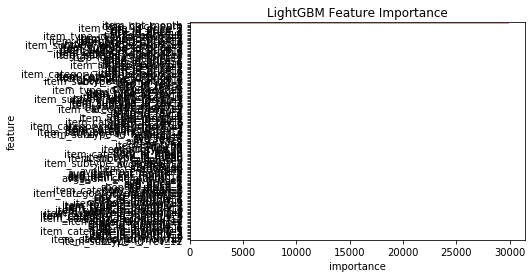

In [52]:
g = sns.barplot(x='importance', y='feature', data=lgb_imp.sort_values(by='importance', ascending=False))
plt.title('LightGBM Feature Importance')

## 4. Prediction

In [44]:
%%time 

X_test = df_test[train_cols]

pred_lgb = fit_lgb.predict(X_test)

Wall time: 1.5 s


In [53]:
lgb_sub = pd.DataFrame(pred_lgb, columns=['item_cnt_month'])
lgb_sub['ID'] = lgb_sub.index
lgb_sub = lgb_sub.set_index('ID')
lgb_sub.to_csv('data/lgb_sub1.csv')

In [54]:
print(lgb_sub.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_cnt_month  214200 non-null  float64
dtypes: float64(1)
memory usage: 3.3 MB
None


In [98]:
lgb_imp = pd.DataFrame()
lgb_imp['feature'] = X_train.columns.values
lgb_imp['importance'] = fit_lgb.feature_importance()

Text(0.5, 1.0, 'LightGBM Feature Importance')

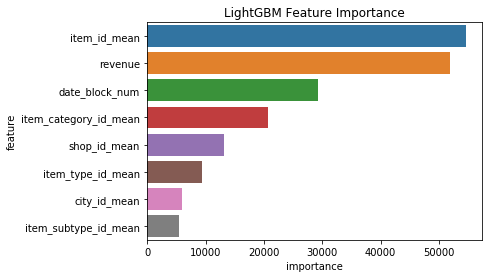

In [99]:
sns.barplot(x='importance', y='feature', data=lgb_imp.sort_values(by='importance', ascending=False))
plt.title('LightGBM Feature Importance')

## 5. Modelling and Prediction - XGBoost

In [57]:
%%time

## Run XGBoost
fit_xgb = xgb.XGBRegressor(max_depth=10, 
                           min_child_weight=0.5, 
                           subsample=1, 
                           eta=0.3, 
                           num_round=1000, 
                           seed=1, 
                           n_jobs=15, 
                           verbosity=2)

fit_xgb.fit(X_train, y_train, eval_metric='rmse')

[16:26:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:26:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:44] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:47] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:26:53] INFO: src/tree/updater_prune.cc:74: tree prunin

[16:28:50] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:28:51] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:28:53] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:28:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:28:57] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:28:59] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:29:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:29:03] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[16:29:05] INFO: src/tree/updater_prune.cc:74: tree prun

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None, n_estimators=100,
             n_jobs=15, nthread=None, num_round=1000, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=1, silent=None, subsample=1, verbosity=2)

In [58]:
%%time

X_test = df_test[train_cols]

pred_xgb = fit_xgb.predict(X_test)

Wall time: 561 ms


In [61]:
xgb_sub = pd.DataFrame(pred_xgb, columns=['item_cnt_month'])
xgb_sub['ID'] = xgb_sub.index
xgb_sub = xgb_sub.set_index('ID')
xgb_sub.to_csv('data/xgb_sub1.csv')

xgb_sub.head(10)

,item_cnt_month
ID,
0,3.999907
1,10.999722
2,1.999960
3,0.999987
4,5.999854
5,4.999880
6,2.999933
7,7.999801
8,4.999880


In [62]:
print(xgb_sub.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_cnt_month  214200 non-null  float32
dtypes: float32(1)
memory usage: 2.5 MB
None
